# Trabajo Práctico 1 - Procesamiento Digital de Señales
Desarrollado por Martín Haimovich e Ignacio Veiga, UNTREF, Octubre de 2022. 

Se destaca la importancia de ejecutar las celdas del presente Notebook de forma secuencial, para asegurar su correcto funcionamiento.

Versión de Python utilizada para el desarrollo: 3.10.0

Para ciertas funcionalidades, como los gráficos hechos con la librería plotly, puede ser necesario actualizar la versión de nbformat (pip install --upgrade nbformat).


Se importan las bibliotecas necesarias

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import random
import plotly.graph_objects as go
import time
import soundfile as sf
import sounddevice as sd
from conv_circular import circular_convolve, _periodic_summation
from scipy.fft import fft, rfft

### Ejercicio 1

Defino los parametros de frecuencia, frecuencia de muestreo, numero de armonicos, tiempo y la cantidad de muestras por 2 segundos.

In [75]:
f0 = 440
fs = 44100
K = 5
signalTime = 2

N = (signalTime*fs)//1

Defino un vector n cuyos elementos irán desde 0 hasta el numero de muestra que se encuentra en el segundo 2, genero el vector tiempo de 2 segundos y defino un vector A que esta lleno de ceros, cuya cantidad de elementos es igual a las muestras en 2 seg (N).

In [76]:
n = np.arange(N)
t = np.linspace(0,2,N)
A = np.zeros(N)

Voy agregandole elementos al vector A (armonicos) y grafico cada armonico. Finalmente, normalizo y grafico la señal completa.

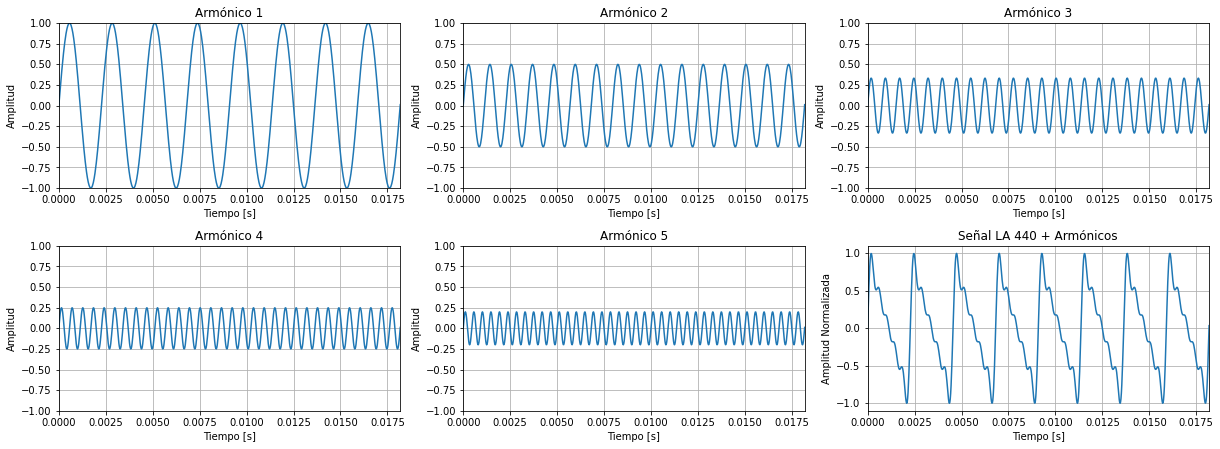

In [77]:
plt.figure(1,figsize=(17,9))
for k in range(1,K+1):
    armonicos = (1/k) * np.sin(2*n*k*np.pi*(f0/fs))
    A += armonicos
    plt.subplot(3,3,k)
    plt.plot(t,armonicos)
    plt.grid()
    plt.xlim(0,(8/f0))
    plt.ylim(-1,1)
    plt.title('Armónico %i' %k)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")   

Amax = np.amax(A)
A = A * (1/Amax)

plt.subplot(3,3,6)
plt.plot(t,A)
plt.grid()
plt.xlim(0,(8/f0))
plt.title('Señal LA 440 + Armónicos')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud Normalizada")

plt.tight_layout()
plt.show()

Se puede ver que la señal resultante se aproxima a una diente de sierra.

### Ejercicio 2

Se definen los parámetros a utilizar

In [78]:
mu = 0
sigma = 1

Se define la funcion para calcular el valor medio de los elementos en un vector

In [79]:
def valor_medio(valores):
    sumatoria = 0
    for i in valores:
        sumatoria += i
    return sumatoria / len(valores)

Se define una funcion para calcular el desvío estandar de los valores de los elementos en un vector

In [80]:
def desvio_estandar(medio, valores):
    sumatoria = 0
    for i in valores:
        sumatoria += (i - medio)**2
    ds = (sumatoria/(len(valores)-1))**0.5
    error = 100-ds*100/1
    return ds, error

Se inicializan arrays para guardar los datos

In [81]:
arrayTabla = [5, 10, 100, 1000, 10000, 100000]
averageArray = []
dsArray = []
errorArray = []

Se itera para dar valores a los arrays creados


In [82]:
for i in arrayTabla:
    L = i
    signal = []
    for i in range(L):
        temp = random.gauss(mu, sigma)
        signal.append(temp)
    average = valor_medio(signal)
    averageArray.append(average)
    ds, error = desvio_estandar(average, signal)
    dsArray.append(ds)
    errorArray.append(np.abs(error))



Gráfico en tabla

In [83]:
DC_SNR_layout = go.Layout(
    title='Desviación Estándar y Error según longitud de señal',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig2 = go.Figure(data=[go.Table(header=dict(values=['L [muestras]', ' Desv. Estándar', 'Error [%]'],align='center'),
                cells=dict(values=[np.array(arrayTabla).astype(str), np.around(dsArray, 2), np.around(errorArray,2)],align='center'))
                ],
                layout=DC_SNR_layout)
fig2.show()

Se puede ver que a medida que la señal aleatoria aumenta su dimensión, el desvío estandar tiende a 1, con un error cada vez menor, aproximandose al caso ideal de distribucion normal

## Ejercicio 3

Defino el desvio estandar de las 3 señales con ruido


In [84]:
sigma1 = 1
sigma2 = 0.1
sigma3 = 3



Defino señales de ruido con desvio estandar 0.1, 1 y 3


In [85]:
x1 = np.random.normal(0, sigma1, len(t))
x2 = np.random.normal(0, sigma2, len(t))
x3 = np.random.normal(0, sigma3, len(t))



Defino 3 señales con cada ruido respectivamente combinado a la señal del ejercicio 1


In [86]:
AX1 = A + x1
AX2 = A + x2
AX3 =  A + x3

Normalizo las 3 señales nuevas


In [87]:
AX1max = np.amax(AX1)
AX1 = AX1 * (1/AX1max)
AX2max = np.amax(AX2)
AX2 = AX2 * (1/AX2max)
AX3max = np.amax(AX3)
AX3 = AX3 * (1/AX3max)

Grafico las 3 señales normalizadas


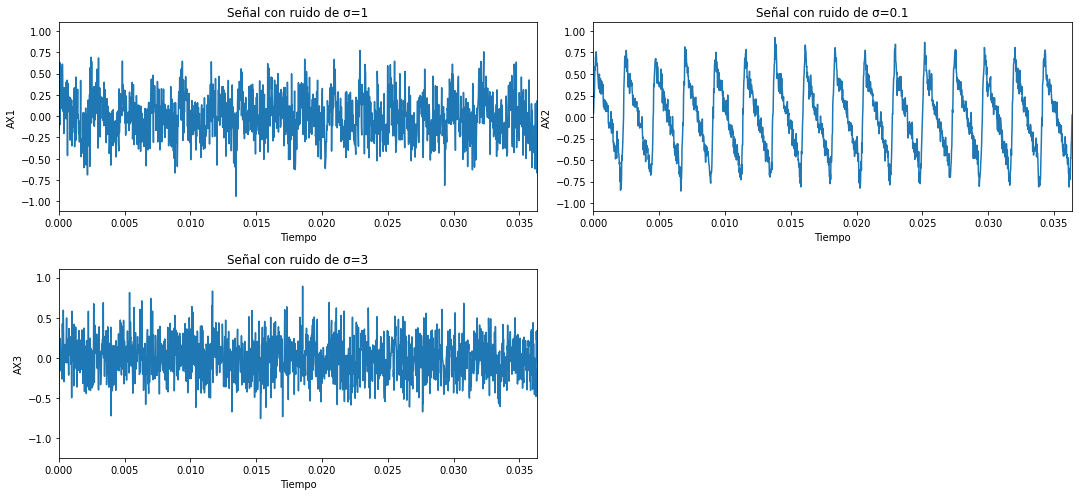

In [88]:
plt.figure(3, figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t, AX1)
plt.title('Señal con ruido de σ=1')
plt.xlabel("Tiempo")
plt.ylabel("AX1")
plt.xlim(0, 16/f0)


plt.subplot(2,2,2)
plt.plot(t, AX2)
plt.title('Señal con ruido de σ=0.1')
plt.xlabel("Tiempo")
plt.ylabel("AX2")
plt.xlim(0, 16/f0)


plt.subplot(2,2,3)
plt.plot(t, AX3)
plt.title('Señal con ruido de σ=3')
plt.xlabel("Tiempo")
plt.ylabel("AX3")
plt.xlim(0, 16/f0)
plt.tight_layout()
plt.show()

Defino formula que calcula relacion señal ruido


In [89]:
def Señal_Ruido(A,sigma,f_A):
    SNR = np.round((np.amax(A)-np.mean(A))/sigma,2)
    return SNR

SNR1 = Señal_Ruido(AX1,sigma1,fs/f0)
SNR2 = Señal_Ruido(AX2,sigma2,fs/f0)
SNR3 = Señal_Ruido(AX3,sigma3,fs/f0)

Agregandole a cada señal un componente de continua con los valores -10, 10 y 1000

In [90]:
DCcomps = [-10, 10, 1000]

AX1_C1 = AX1 + DCcomps[0]
AX2_C1 = AX2 + DCcomps[0]
AX3_C1 = AX3 + DCcomps[0]

AX1_C2 = AX1 + DCcomps[1]
AX2_C2 = AX2 + DCcomps[1]
AX3_C2 = AX3 + DCcomps[1]

AX1_C3 = AX1 + DCcomps[2]
AX2_C3 = AX2 + DCcomps[2]
AX3_C3 = AX3 + DCcomps[2]

Se calcula SNR a cada señal con componente de continua


In [91]:
SNR4 = Señal_Ruido(AX1_C1,sigma1,fs/f0)
SNR5 = Señal_Ruido(AX2_C1,sigma2,fs/f0)
SNR6 = Señal_Ruido(AX3_C1,sigma3,fs/f0)

SNR7 = Señal_Ruido(AX1_C2,sigma1,fs/f0)
SNR8 = Señal_Ruido(AX2_C2,sigma2,fs/f0)
SNR9 = Señal_Ruido(AX3_C2,sigma3,fs/f0)

SNR10 = Señal_Ruido(AX1_C3,sigma1,fs/f0)
SNR11 = Señal_Ruido(AX2_C3,sigma2,fs/f0)
SNR12 = Señal_Ruido(AX3_C3,sigma3,fs/f0)

DC_SNR_layout = go.Layout(
    title='Relaciones Señal-Ruido para distintas desviaciones estándar',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig4 = go.Figure(data=[go.Table(header=dict(values=['Señal con ruido', 'Sigma', 'SNR', 'SNR con DC=-10', 'SNR con DC=10', 'SNR con DC=1000'],align='center'),
                cells=dict(values=[["Señal 1", "Señal 2", "Señal 3"], [sigma1, sigma2, sigma3] , [SNR1, SNR2, SNR3], [SNR4, SNR5, SNR6], [SNR7, SNR8, SNR9], [SNR10, SNR11, SNR12]],align='center'))
                ],
                layout=DC_SNR_layout)
fig4.show()



A medida que el desvio estandar es menor, la relacion señal ruido aumenta, lo cual es coherente con la formula planteada.

El SNR no se modifica con la adición de una componente de continua.

## Ejercicio 4

Se define la función para calcular el promedio en ensamble.



In [92]:
def promedio_ensamble(N):
    # Inicializo Array
    randNoiseSignals = []    

    # Creo las señales y las guardo en el array
    for i in range(N):
        A_randNoise = A + np.random.normal(0, 3, len(t))
        randNoiseSignals.append(A_randNoise)

    # Inicializo un nuevo array que será el promedio, y transpongo el array de señales con ruido para poder sumar los valores para el promedio
    averageA_RN = []
    randNoiseSignals_T = np.array(randNoiseSignals).transpose()
    for i in range(len(randNoiseSignals[0])):
        averageA_RN.append((1/10) * np.sum(randNoiseSignals_T[i]))

    # Mido SNR
    SNR_average = Señal_Ruido(averageA_RN,3,fs/f0)

    # Normalizo
    Amax = np.amax(averageA_RN)
    averageA_RN = averageA_RN / Amax

    return randNoiseSignals, averageA_RN, SNR_average



Se utiliza la función para 10, 100 y 1000 señales.



In [93]:
randNoiseSignals10, averageA_RN10, SNR_average10 = promedio_ensamble(10)
randNoiseSignals100, averageA_RN100, SNR_average100 = promedio_ensamble(100)
randNoiseSignals1000, averageA_RN1000, SNR_average1000 = promedio_ensamble(1000)

Se grafica.



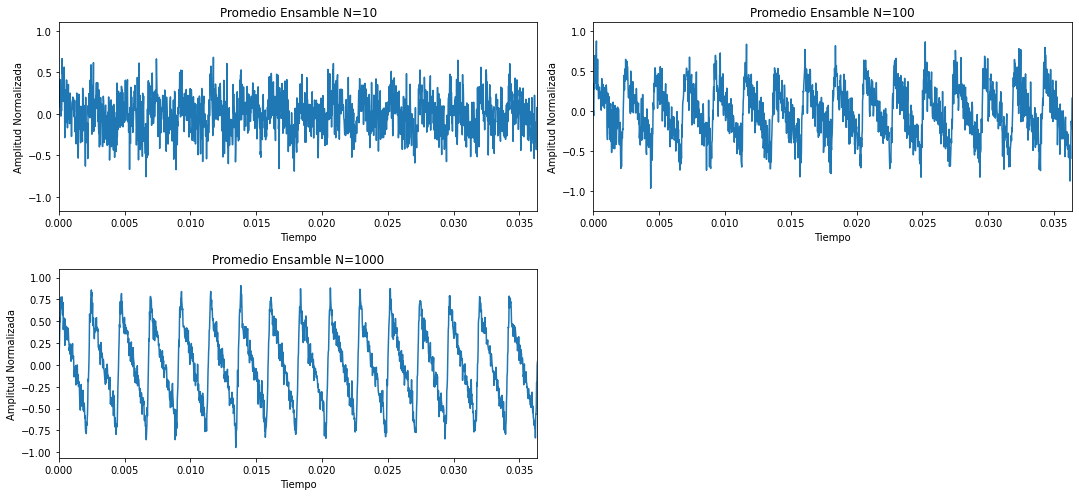

In [94]:
plt.figure(5, figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t, averageA_RN10)
plt.title('Promedio Ensamble N=10')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)


plt.subplot(2,2,2)
plt.plot(t, averageA_RN100)
plt.title('Promedio Ensamble N=100')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)


plt.subplot(2,2,3)
plt.plot(t, averageA_RN1000)
plt.title('Promedio Ensamble N=1000')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)
plt.tight_layout()
plt.show()

Se genera tabla de SNRs.

In [95]:
DC_SNR_layout = go.Layout(
    title='SNR para Promedio Ensamble',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig6 = go.Figure(data=[go.Table(header=dict(values=['Cantidad de señales de ruido', 'SNR promedio', 'SNR ejercicio 3'],align='center'),
                cells=dict(values=[["10", "100", "1000"], [SNR_average10, SNR_average100, SNR_average1000], [SNR1, SNR2, SNR3]],align='center'))
                ],
                layout=DC_SNR_layout)
fig6.show()

Se observa que para mayor cantidad de señales, mayor será el SNR del promedio.

## Ejercicio 5 

Se definen las funciones para implementar el filtro de manera directa, o con la implementación recursiva explicada en las bibliografía de referencia.

In [96]:
# Directa
def mediaMovilD(x, M):
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    y = np.zeros(len(x))
    for i in range(M//2, len(x) - M//2):
        y[i] = 0.0
        for j in range(-M//2, M//2 + 1):
            y[i] += x[i+j]
        y[i] = y[i] / M
    return y

# Recursiva
def mediamovildr(x,M):
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    if len(x)>M:
        y = np.zeros(len(x))
        acc=0.0
        for i in range(0,M):
            acc += x[i]
        y[M//2] = acc/M
        for i in range((M//2)+1,(len(y)-(M//2))):
            acc = acc + x[i+((M-1)//2)]-x[i-(((M-1)//2)+1)]
            y[i] = acc/M
        return y
    else:
        s=len(x)-M
        return np.hstack([np.zeros(M-1),np.mean(x[s:s+M-1])])

### Definición de ventana
Se genera una función para calcular la reducción de un filtro de media móvil de ventana M para una frecuencia dada.

In [97]:
def response_MA_f (x ,M, f, fs=44100, pref=0.00002):

    # Creo sinusoide de frecuencia buscada y aplico filtro MA de ancho M
    sig = np.sin(2*np.arange(len(x))*np.pi*(f/fs))

    MA = mediamovildr(sig, M)

    # Respuesta para la frecuencia buscada
    res = np.amax(MA)/np.amax(sig)

    return res

Se busca mediante iteración y comparación un número de muestras de la ventana que permita una atenuación de al menos el 90% en 880 Hz y frecuencias superiores. En principio se define una función para recorrer los posibles valores de M.

In [98]:
def M_for_response(x,f,response,fs=44100, pref=0.00002):
    for i in range(1,fs//2):
        res = np.zeros(len(f))
        flag = 0
        for j in range(len(f)):    
            res[j] = response_MA_f(x,i,f[j])
            if res[j] < response:
                flag += 1
        if flag == len(f):
            M_for_R = i
            break
    return M_for_R

Como las señales tienen la misma longitud, basta con desarrollar sólo para una de ellas.

In [99]:
M_minus90_AX1 = M_for_response(AX1,[880, 1320, 1760, 2200], 0.1)

print("Largo de Ventana MA para atenuar 90%:", M_minus90_AX1)

Largo de Ventana MA para atenuar 90%: 91


Se chequea que se cumpla la atenuación para todos los armónicos

In [100]:
att_MA_440 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440)),2)
att_MA_880 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*2)),2)
att_MA_1320 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*3)),2)
att_MA_1760 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*4)),2)
att_MA_2200 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*5)),2)

DC_SNR_layout = go.Layout(
    title='Atenuación por MA de M=%i según frecuencia' %M_minus90_AX1,
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig7 = go.Figure(data=[go.Table(header=dict(values=['Frecuencia', 'Atenuación [%]'],align='center'),
                cells=dict(values=[['440 Hz:','880 Hz:','1320 Hz:','1760 Hz:','2200 Hz:'], [att_MA_440, att_MA_880, att_MA_1320, att_MA_1760, att_MA_2200]],align='center'))
                ],
                layout=DC_SNR_layout)
fig7.show()

Son todos menores a 0.1, pero 440 Hz también se encuentra atenuado en casi un 90%, por lo cual no sería la condición buscada.

Se busca entonces filtrar las frecuencias mayores a 880 Hz en un 90% en promedio.

In [101]:
def M_for_response_f(x,f,response,fs=44100, pref=0.00002):
    for i in range(1,fs//2):
        res = np.zeros(len(f))
        for j in range(len(f)):    
            res[j] = response_MA_f(x,i,f[j])
        if np.average(res) < response:
            M_for_R = i
            break
    return M_for_R

M_minus90_avg = M_for_response_f(AX1,[880, 1320, 1760, 2200], 0.1)

print("Largo de Ventana MA para atenuar 90% en promedio:", M_minus90_avg)

Largo de Ventana MA para atenuar 90% en promedio: 49


Se chequea que se cumpla la atenuación para todos los armónicos

In [102]:
att_MA_avg_440 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440)),2)
att_MA_avg_880 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*2)),2)
att_MA_avg_1320 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*3)),2)
att_MA_avg_1760 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*4)),2)
att_MA_avg_2200 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*5)),2)

DC_SNR_layout = go.Layout(
    title='Atenuación por MA de M=%i según frecuencia' %M_minus90_avg,
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig8 = go.Figure(data=[go.Table(header=dict(values=['Frecuencia', 'Atenuación [%]'],align='center'),
                cells=dict(values=[['440 Hz:','880 Hz:','1320 Hz:','1760 Hz:','2200 Hz:'], [att_MA_avg_440, att_MA_avg_880, att_MA_avg_1320, att_MA_avg_1760, att_MA_avg_2200]],align='center'))
                ],
                layout=DC_SNR_layout)
fig8.show()

En este caso se logra filtrar los armónicos mayores manteniendo un 65% de la frecuencia fundamental, por lo cual resulta apropiado como largo de la ventana para el filtro.

El valor de 49 muestras resulta lógico, ya que es cercano al número de muestras por cada período de la frecuencia de 880 Hz (44100/440 = 50 muestras aprox.), lo cual significa que cada ciclo de esa frecuencia está siendo prácticamente eliminado al promediarse. Los otros armónicos tienen períodos de 33, 25 y 20 muestras, lo cual implica que el de 25, al entrar 2 veces en 50, tendrá una atenuación similar al de 50 muestras, mientras que los otros dos no tendrán tanta atenuación, lo cual se observa en los resultados anteriores.

### Implementación de filtros con ventana elegida y medición del tiempo de ejecución

Implementación directa

El tiempo que tarda el filtro directo en ejecutarse es de 2.19 segundos


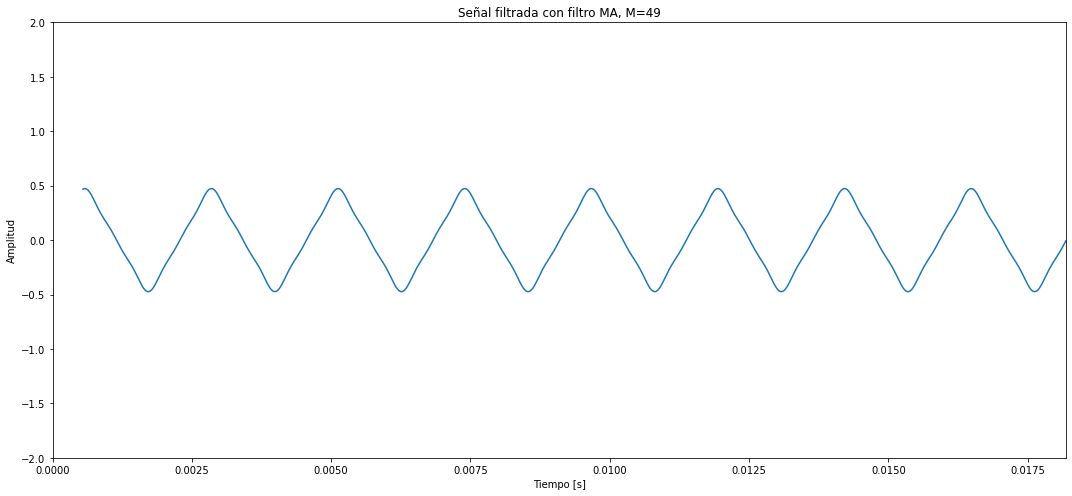

In [103]:
inicio = time.time()
filtranding = mediaMovilD(A, M_minus90_avg)
final = time.time()
tiempo = final-inicio
print("El tiempo que tarda el filtro directo en ejecutarse es de " +str(round(tiempo,2))+ " segundos")

plt.figure(9, figsize=(15,7))
plt.plot(t[M_minus90_avg//2:], filtranding[M_minus90_avg//2:])
plt.title('Señal filtrada con filtro MA, M=49')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(0, 8/f0)
plt.ylim(-2,2)

plt.tight_layout()
plt.show()

Implementación recursiva

El tiempo que tarda el filtro de implementación recursiva en ejecutarse es de 0.1 segundos


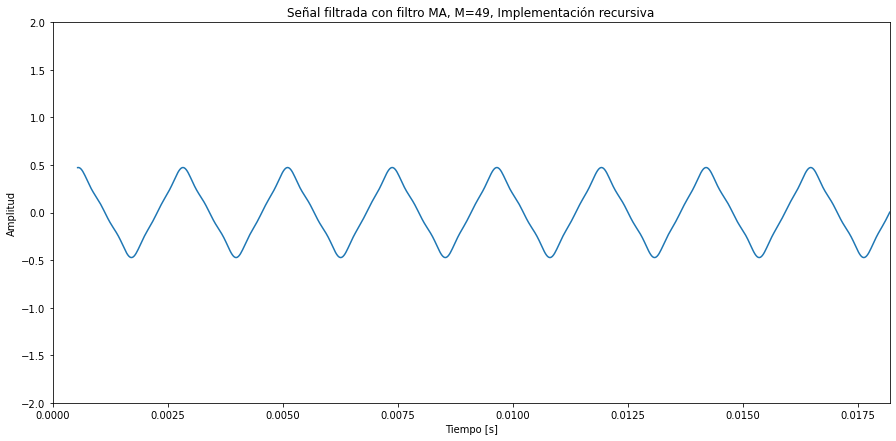

In [104]:
inicio = time.time()
xfr = mediamovildr(A,M_minus90_avg)
final = time.time()
tiempo = final-inicio
print("El tiempo que tarda el filtro de implementación recursiva en ejecutarse es de " +str(round(tiempo,2))+ " segundos")

plt.figure(10, figsize=(15,7))
plt.plot(t[M_minus90_avg//2:], xfr[M_minus90_avg//2:])
plt.title('Señal filtrada con filtro MA, M=49, Implementación recursiva')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(0, 8/f0)
plt.ylim(-2,2)

plt.show()

Se puede concluir que la implementacion recursiva realiza los calculos en un tiempo mucho menor que la de implementacion directa.

## Ejercicio 6

Se utiliza la ventana obtenida en el ejercicio 5.

In [105]:
M = 50

Genero la respuesta al impulso y la convoluciono con la señal. Grafico la señal filtrada del ejercicio 5 junto con el resultado de la convolución.

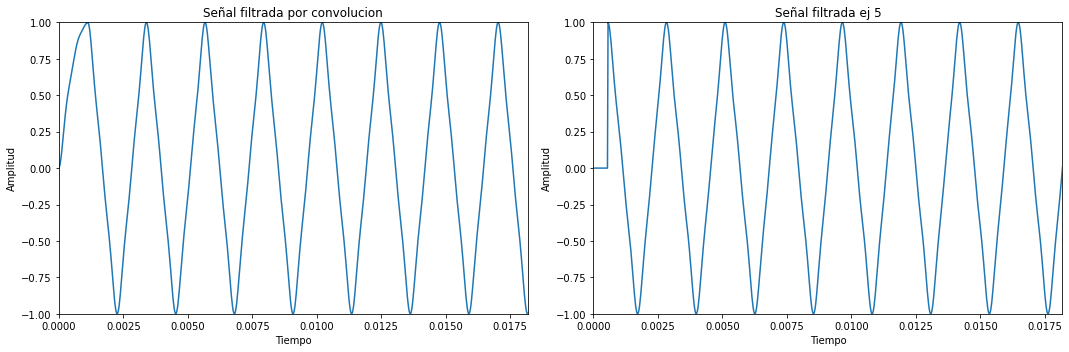

In [106]:
w = 1/M * np.append(np.ones(M), np.zeros(len(t)-M))
#Hago la convolucion entre la ventana y la señal
h = sig.convolve(A, w, mode='full')
h = h / np.amax(h)
   
plt.figure(11, figsize=(15,5))

#Grafico la convolucion entre w y la señal del ejercicio 1
plt.subplot(1,2,1)
plt.plot(t, h[0:len(t)])
plt.xlim(0, 8/f0)
plt.ylim(-1,1)
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.title("Señal filtrada por convolucion")

plt.subplot(1,2,2)
# Usando implementación recursiva
filtranding = mediamovildr(A, M)
# Normalizo
filtranding = filtranding / np.amax(filtranding)
plt.plot(t, filtranding)
plt.xlim(0, 8/f0)
plt.ylim(-1,1)
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.title("Señal filtrada ej 5")

plt.tight_layout()
plt.show()

Se llega al mismo resultado tanto haciendo la convolucion como utilizando una de las funciones del ejercicio 5. Sólo se observa una diferencia en el comienzo de la señal, relacionado a cómo el algoritmo sig. convolve maneja las muestras iniciales.

## Ejercicio 7

Defino M y genero ventana de Blackman

In [107]:
M = 50

a0 = 0.42
a1 = 0.5
a2 = 0.08
blackMan = np.zeros(M)
for i in range(M):
    blackMan[i] = a0 - a1 * np.cos((2*np.pi*i)/(M-1)) + a2 * np.cos((4*np.pi*i)/(M-1)) 

Convoluciono el filtro de  Blackman con la señal del ejercicio 1

In [108]:
convBlack = np.convolve(A, blackMan, mode='full')
# Normalizo
convBlack = convBlack / np.amax(convBlack)

Defino muestras iniciales y finales para graficar la señal filtrada quitando las muestras agregadas por la convolución en los extremos. Grafico resultado.

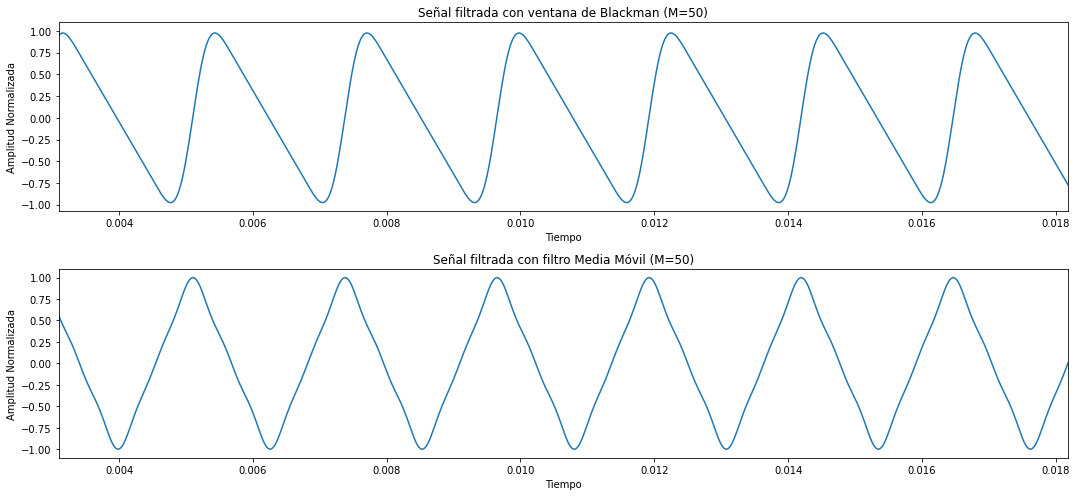

In [109]:
convBlackStart = ( (len(convBlack)-len(t)) // 2 )
convBlackEnd = ( (len(convBlack)+len(t)) // 2 )

plt.figure(12, figsize=(15,7))
plt.subplot(211)
plt.plot(t, convBlack[0:len(t)])
plt.xlim(0.0031, 8/f0)
plt.title('Señal filtrada con ventana de Blackman (M=50)')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")

plt.subplot(212)
plt.plot(t, filtranding)
plt.xlim(0.0031, 8/f0)
plt.title('Señal filtrada con filtro Media Móvil (M=50)')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")

plt.tight_layout()
plt.show()


Se puede apreciar que el filtraje con la ventana Blackman es mucho mejor que el realizado en los ejercicios 5 y 6, dando una senoidal más aproximada al primer armonico de la señal original.

## Ejercicio 8

Importo archivo de audio y lo guardo en variable respuesta al impulso h.

In [110]:
h, fs = sf.read('Resp_Imp.wav')

Defino funciones a utilizar y las aplico a la señal.

In [111]:
#Convolucion lineal
conv = sig.fftconvolve(A, h, mode='full')
conv = conv / np.amax(conv)

#Convolucion circular
conv_circ = circular_convolve(A, h, len(h))
conv_circ = conv_circ / np.amax(conv_circ)

#Convolucion lineal mismo periodo que la circular
circ_lin = circular_convolve(A, h, len(conv))
circ_lin = circ_lin / np.amax(circ_lin)

Grafico las señales convolucionadas

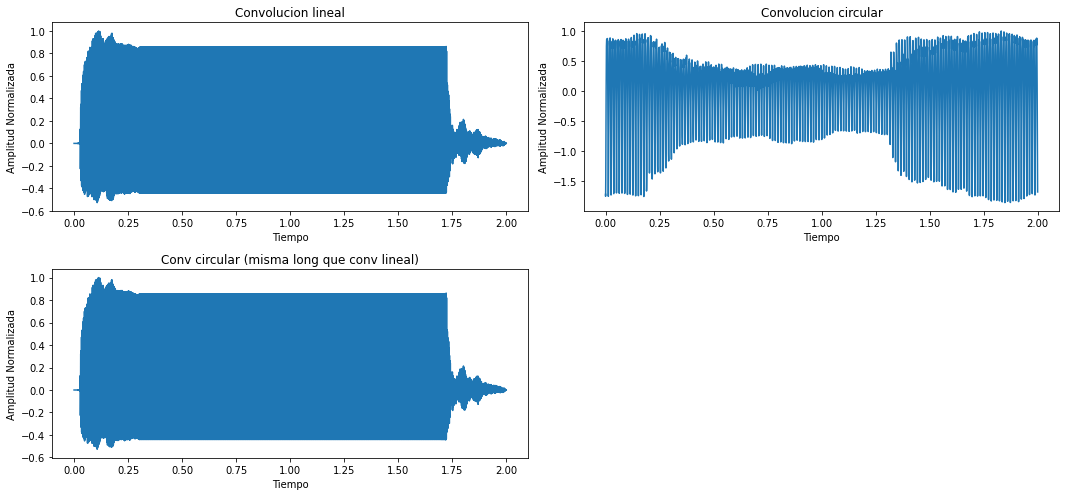

In [112]:
#Genero vectores de tiempo para cada señal a graficar
t1 = np.linspace(0,2,len(conv))
t2 = np.linspace(0,2,len(conv_circ))
t3 = np.linspace(0,2,len(circ_lin))

#Grafico convolucion lineal
plt.figure(13, figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t1, conv)
plt.title("Convolucion lineal")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")

#Grafico convolucion circular
plt.subplot(2,2,2)
plt.plot(t2, conv_circ)
plt.title("Convolucion circular")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")

#Grafico convolucion circular de misma longitud que la lineal
plt.subplot(2,2,3)
plt.plot(t3, circ_lin)
plt.title("Conv circular (misma long que conv lineal)")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")

plt.tight_layout()
plt.show()

Genero audios de las señales convolucionadas.

In [113]:
sf.write('Conv.wav',conv,fs)
sf.write('Conv_circular.wav',conv_circ,fs)
sf.write('Circular_igual_lineal.wav',circ_lin,fs)

La señal convolucionada linealmente y la convolucionada circular con las mismas muestras que la lineal dan graficos identicos por lo que el calculo es coherente.

Ademas, se escucha en los archivos de audio a la misma señal del ejercicio 1 con una pequeña reverb producto de ser convolucionada con la respuesta al impulso de un recinto.

Se puede ver en los graficos que la convolucion circular tiene menos muestras que las demas convoluciones.


## Ejercicio 9

Se define función signo con sgn(0)=1 , como se describe en la referencia.

In [114]:
def sgn(t):
    if t<0:
        return -1
    elif t>=0:
        return 1
    else:
        raise Exception('Invalid input. Input must be an integer or float.')

Defino las funciones genéricamente.

In [115]:
def shortTimeEnergy(M,x,hop):
    if len(x) < (hop-M):
        raise Exception('El salto entre frames no debe tener más muestras que la señal a filtrar menos la ventana de cada frame')
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    ste = np.zeros((len(x)-M)//hop)
    w = np.hamming(M)
    for i in range(0,((len(x)-M)//hop)):
        for j in range(0,M):
            if (j+(i*hop)) < ((len(x)-M+1)):
                y = x[j+(i*hop)] * w[j]
                ste[i] += ( ((y)**2) / M )   
    return ste

def zeroCrossingRate(M,x,hop):
    if len(x) < (hop-M):
        raise Exception('El salto entre frames no debe tener más muestras que la señal a filtrar menos la ventana de cada frame')    
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    zcr = np.zeros((len(x)-M)//hop)
    w = np.hamming(M)
    for i in range(0,((len(x)-M)//hop)):
        for j in range(1,M):
            if (j+(i*hop)) < (len(x)-M+1):
                y = x[j+(i*hop)] * w[j]
                zcr[i] += np.abs( ( (sgn(y)) - (sgn(x[j+(i*hop)-1]*w[j-1])) ) / (2*M) )    
    return zcr

def energyEntropy(M,x,K,hop):
    if len(x) < (hop-M):
        raise Exception('El salto entre frames no debe tener más muestras que la señal a filtrar menos la ventana de cada frame')
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    if M<K:
        raise Exception('La ventana K no debe tener más muestras que la ventana M')
    enen = np.zeros((len(x)-M)//hop)
    w = np.hamming(M)
    for i in range(0,((len(x)-M)//hop)):
        eTotSF = ( np.sum(shortTimeEnergy(K, x[(i*hop):(i*hop)+M], hop//(M//K))) )
        for j in range(0,M-K):
            if (j+(i*hop)+K) < (len(x)-M+1):
                y = np.multiply(x[j+(i*hop):j+(i*hop)+K], w[j:j+K])
                if np.abs(eTotSF) > 0:
                    ej = np.sum( np.multiply(y,y) / (K) ) / eTotSF
                    if np.abs(ej) > 0:
                        enen[(i)] += (-1) * ej * np.log2(ej)  
    return enen

Importo las señales.

In [116]:
signal1, fs = sf.read('Sen_al1.wav')
signal2, fs = sf.read('Sen_al2.wav')
signal3, fs = sf.read('Sen_al3.wav')

Calculo los parámetros temporales de las señales y grafico.

### Short-Time Energy

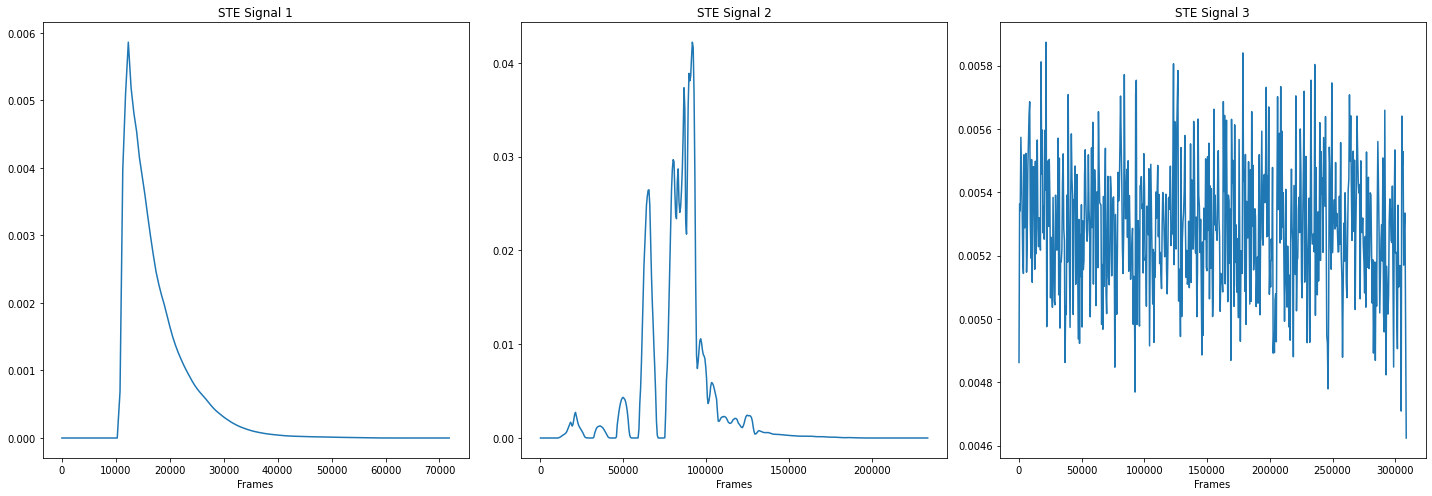

In [117]:
STE1 = shortTimeEnergy(1000, signal1, 500)
STE2 = shortTimeEnergy(1000, signal2, 500)
STE3 = shortTimeEnergy(1000, signal3, 500)

plt.figure(14, figsize=(20,7))
plt.subplot(1,3,1)
plt.title('STE Signal 1')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal1),len(STE1)), np.array(STE1))
plt.subplot(1,3,2)
plt.title('STE Signal 2')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal2),len(STE2)), np.array(STE2))
plt.subplot(1,3,3)
plt.title('STE Signal 3')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal3),len(STE3)), np.array(STE3))

plt.tight_layout()
plt.show()

### Zero-Crossing Rate

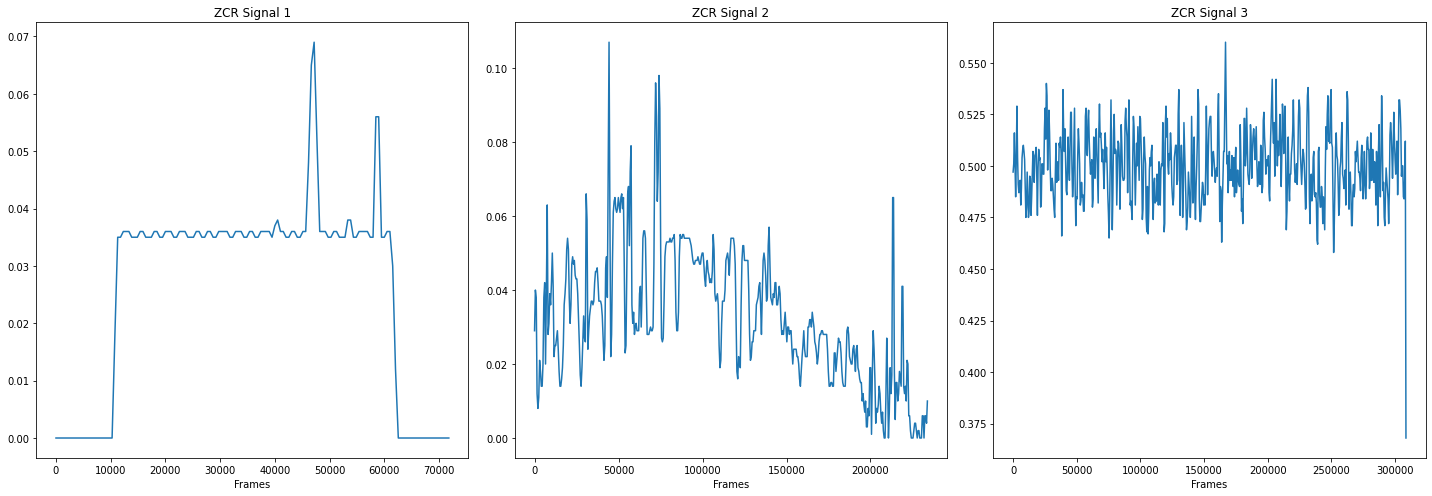

In [118]:

ZCR1 = zeroCrossingRate(1000, signal1, 500)
ZCR2 = zeroCrossingRate(1000, signal2, 500)
ZCR3 = zeroCrossingRate(1000, signal3, 500)

plt.figure(15, figsize=(20,7))
plt.subplot(1,3,1)
plt.title('ZCR Signal 1')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal1),len(ZCR1)), np.array(ZCR1))
plt.subplot(1,3,2)
plt.title('ZCR Signal 2')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal2),len(ZCR2)), np.array(ZCR2))
plt.subplot(1,3,3)
plt.title('ZCR Signal 3')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal3),len(ZCR3)), np.array(ZCR3))

plt.tight_layout()
plt.show()

### Energy Entropy

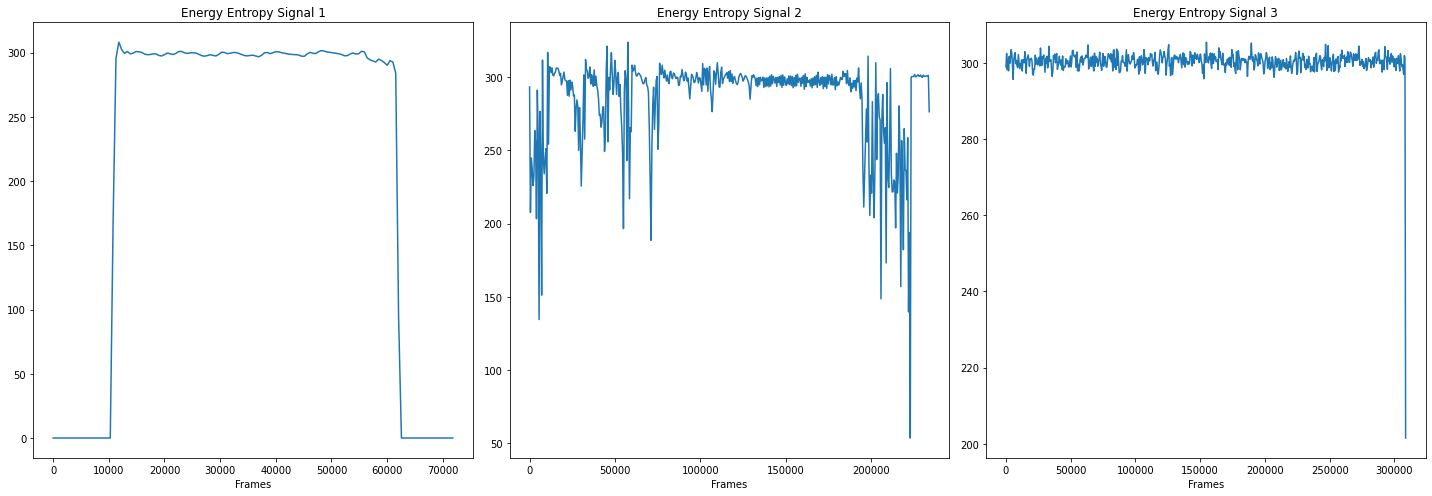

In [119]:

ENEN1 = energyEntropy(1000, signal1, 200, 500)
ENEN2 = energyEntropy(1000, signal2, 200, 500)
ENEN3 = energyEntropy(1000, signal3, 200, 500)

plt.figure(16, figsize=(20,7))
plt.subplot(1,3,1)
plt.title('Energy Entropy Signal 1')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal1),len(ENEN1)), np.array(ENEN1))
plt.subplot(1,3,2)
plt.title('Energy Entropy Signal 2')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal2),len(ENEN2)), np.array(ENEN2))
plt.subplot(1,3,3)
plt.title('Energy Entropy Signal 3')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal3),len(ENEN3)), np.array(ENEN3))

plt.tight_layout()
plt.show()

## Ejercicio 10

Defino las funciones genéricamente.

In [120]:

def spectralCentroid(M,x,hop):
    if len(x) < (hop-M):
        raise Exception('El salto entre frames no debe tener más muestras que la señal a filtrar menos la ventana de cada frame')
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    spectCen = np.zeros((len(x)-M)//hop)
    w = np.hamming(M)
    for i in range(0,((len(x)-M)//hop)):
        y = np.multiply(x[(i*hop):(i*hop)+M],w)
        X = np.abs(np.fft.rfft(y))
        Xsum = np.sum(X)
        jXsum = 0
        for j in range(len(X)):
            jXsum += (j)*X[j]
        spectCen[i] += jXsum/Xsum       
    return spectCen  

def spectralFlux(M,x,hop):
    if len(x) < (hop-M):
        raise Exception('El salto entre frames no debe tener más muestras que la señal a filtrar menos la ventana de cada frame')
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    spectFlux = np.zeros((len(x)-M)//hop)
    w = np.hamming(M)
    for i in range(0,((len(x)-M)//hop)):
        y = np.multiply(x[(i*hop):(i*hop)+M],w)
        X = np.abs(np.fft.rfft(y))
        Xsum = np.sum(X)
        for j in range(1,len(X)):
            EN = X[j]/Xsum
            prevEN = X[j-1]/Xsum
            spectFlux[i] +=  (EN - prevEN)**2      
    return spectFlux  

def spectralRolloff(M,x,hop,C):
    if C>1 or C<0:
        raise Exception('C debe ser un número entre 0 y 1')
    if len(x) < (hop-M):
        raise Exception('El salto entre frames no debe tener más muestras que la señal a filtrar menos la ventana de cada frame')
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    spectROff = np.zeros((len(x)-M)//hop)
    w = np.hamming(M)
    for i in range(0,((len(x)-M)//hop)):
        y = np.multiply(x[(i*hop):(i*hop)+M],w)
        X = np.abs(np.fft.rfft(y))
        Xfreqs = np.fft.rfftfreq(len(y), d=1./fs)
        Xsum = np.sum(X)
        for j in range(1,len(X)):
            if np.sum(X[1:j]) > (C*Xsum):
                spectROff[i] = Xfreqs[j]
                break
    return spectROff

Importo las señales.

In [121]:
signal1, fs = sf.read('Sen_al1.wav')
signal2, fs = sf.read('Sen_al2.wav')
signal3, fs = sf.read('Sen_al3.wav')

Calculo los parámetros frecuenciales de las señales y grafico.

### Spectral Centroid

C:\Users\Ignacio\AppData\Local\Temp/ipykernel_4468/4127812162.py:15: RuntimeWarning:

invalid value encountered in double_scalars



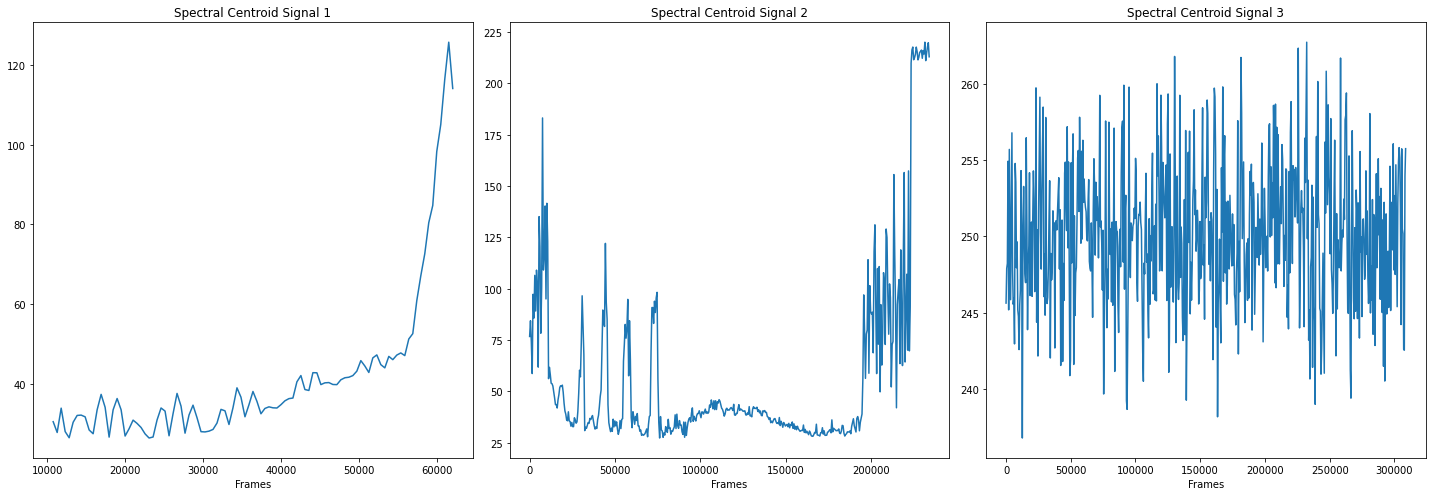

In [122]:
SC1 = spectralCentroid(1000, signal1, 500)
SC2 = spectralCentroid(1000, signal2, 500)
SC3 = spectralCentroid(1000, signal3, 500)

plt.figure(17,figsize=(20,7))
plt.subplot(1,3,1)
plt.title('Spectral Centroid Signal 1')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal1),len(SC1)), np.array(SC1))
plt.subplot(1,3,2)
plt.title('Spectral Centroid Signal 2')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal2),len(SC2)), np.array(SC2))
plt.subplot(1,3,3)
plt.title('Spectral Centroid Signal 3')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal3),len(SC3)), np.array(SC3))

plt.tight_layout()
plt.show()

### Spectral Flux

C:\Users\Ignacio\AppData\Local\Temp/ipykernel_4468/4127812162.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Ignacio\AppData\Local\Temp/ipykernel_4468/4127812162.py:31: RuntimeWarning:

invalid value encountered in double_scalars



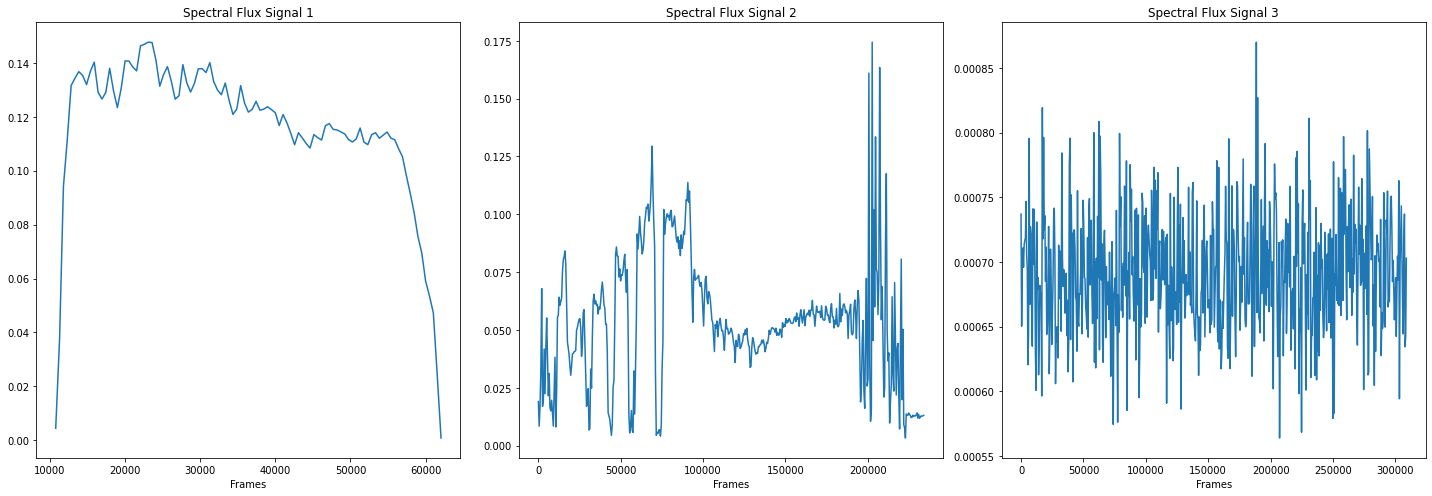

In [123]:
SF1 = spectralFlux(1000, signal1, 500)
SF2 = spectralFlux(1000, signal2, 500)
SF3 = spectralFlux(1000, signal3, 500)

plt.figure(18,figsize=(20,7))
plt.subplot(1,3,1)
plt.title('Spectral Flux Signal 1')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal1),len(SF1)), np.array(SF1))
plt.subplot(1,3,2)
plt.title('Spectral Flux Signal 2')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal2),len(SF2)), np.array(SF2))
plt.subplot(1,3,3)
plt.title('Spectral Flux Signal 3')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal3),len(SF3)), np.array(SF3))

plt.tight_layout()
plt.show()

### Spectral Rolloff

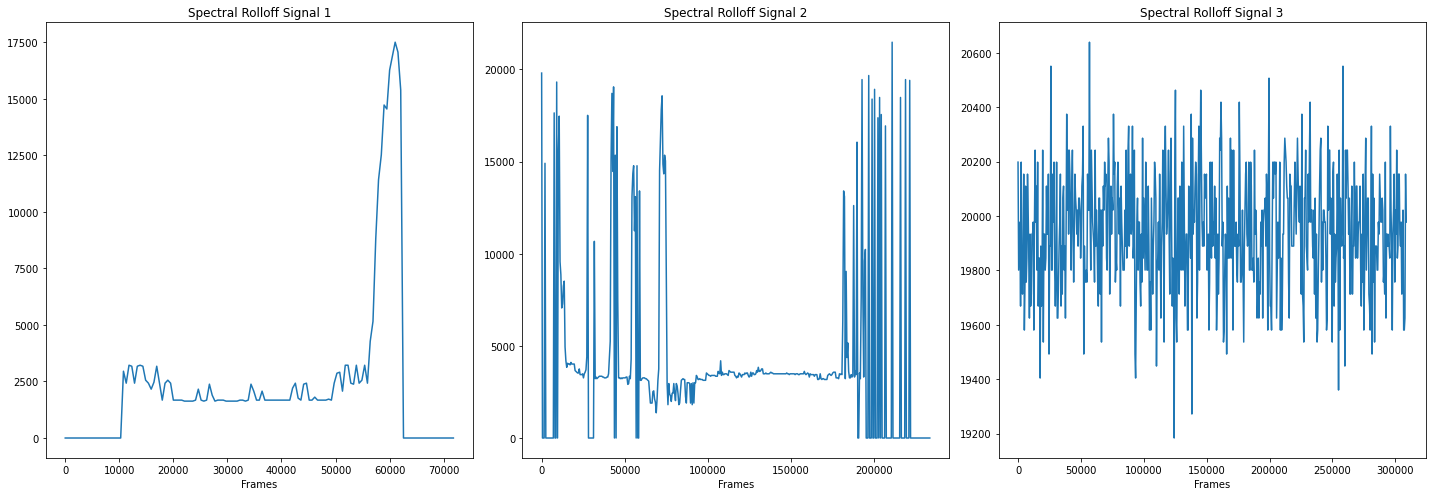

In [124]:
SROff1 = spectralRolloff(1000, signal1, 500, 0.9)
SROff2 = spectralRolloff(1000, signal2, 500, 0.9)
SROff3 = spectralRolloff(1000, signal3, 500, 0.9)

plt.figure(19,figsize=(20,7))
plt.subplot(1,3,1)
plt.title('Spectral Rolloff Signal 1')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal1),len(SROff1)), np.array(SROff1))
plt.subplot(1,3,2)
plt.title('Spectral Rolloff Signal 2')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal2),len(SROff2)), np.array(SROff2))
plt.subplot(1,3,3)
plt.title('Spectral Rolloff Signal 3')
plt.xlabel('Frames')
plt.plot(np.linspace(0,len(signal3),len(SROff3)), np.array(SROff3))

plt.tight_layout()
plt.show()

## Ejercicio 11

Se generan las ventanas.

In [125]:
M = len(A)
w = np.ones(M)
hann = (0.5 - 0.5 * np.cos((2*np.pi*np.arange(M))/M))
blackMan = 0.42 - 0.5 * np.cos((2*np.pi*np.arange(M))/(M-1)) + 0.08 * np.cos((4*np.pi*np.arange(M))/(M-1))

Se multiplica a cada señal por cada ventana.

In [126]:
#Multiplico las señales por la ventana rectangular
A_w = A * w
AX1_w = AX1 * w
AX2_w = AX2 * w
AX3_w = AX3 * w

#Multiplico las señales por la ventana de Hann
A_h = A * hann
AX1_h = AX1 * hann
AX2_h = AX2 * hann
AX3_h = AX3 * hann

#Multiplico las señales por la ventana de Blackman
A_b = A * blackMan
AX1_b = AX1 * blackMan
AX2_b = AX2 * blackMan
AX3_b = AX3 * blackMan

Se obtienen las transformadas de las señales ventaneadas.

In [127]:
# Hago la DFT de las señales multiplicadas por la ventana rectangular
A_w_dft = np.abs(rfft(A_w))
AX1_w_dft = np.abs(rfft(AX1_w))
AX2_w_dft = np.abs(rfft(AX2_w))
AX3_w_dft = np.abs(rfft(AX3_w))

# Hago la DFT de las señales multiplicadas por la ventana de Hann
A_h_dft = np.abs(rfft(A_h))
AX1_h_dft = np.abs(rfft(AX1_h))
AX2_h_dft = np.abs(rfft(AX2_h))
AX3_h_dft = np.abs(rfft(AX3_h))

# Hago la DFT de las señales multiplicadas por la ventana de Blackman
A_b_dft = np.abs(rfft(A_b))
AX1_b_dft = np.abs(rfft(AX1_b))
AX2_b_dft = np.abs(rfft(AX2_b))
AX3_b_dft = np.abs(rfft(AX3_b))

Creo vector de frecuencias para graficar las DFTs

In [128]:
f = np.arange(0, fs//2, (fs//2)/len(A_w_dft)) 
#Podria haber dividido a la mitad de fs por la longitud de cualquiera de las transformadas

Gráfico de las trnasformadas.

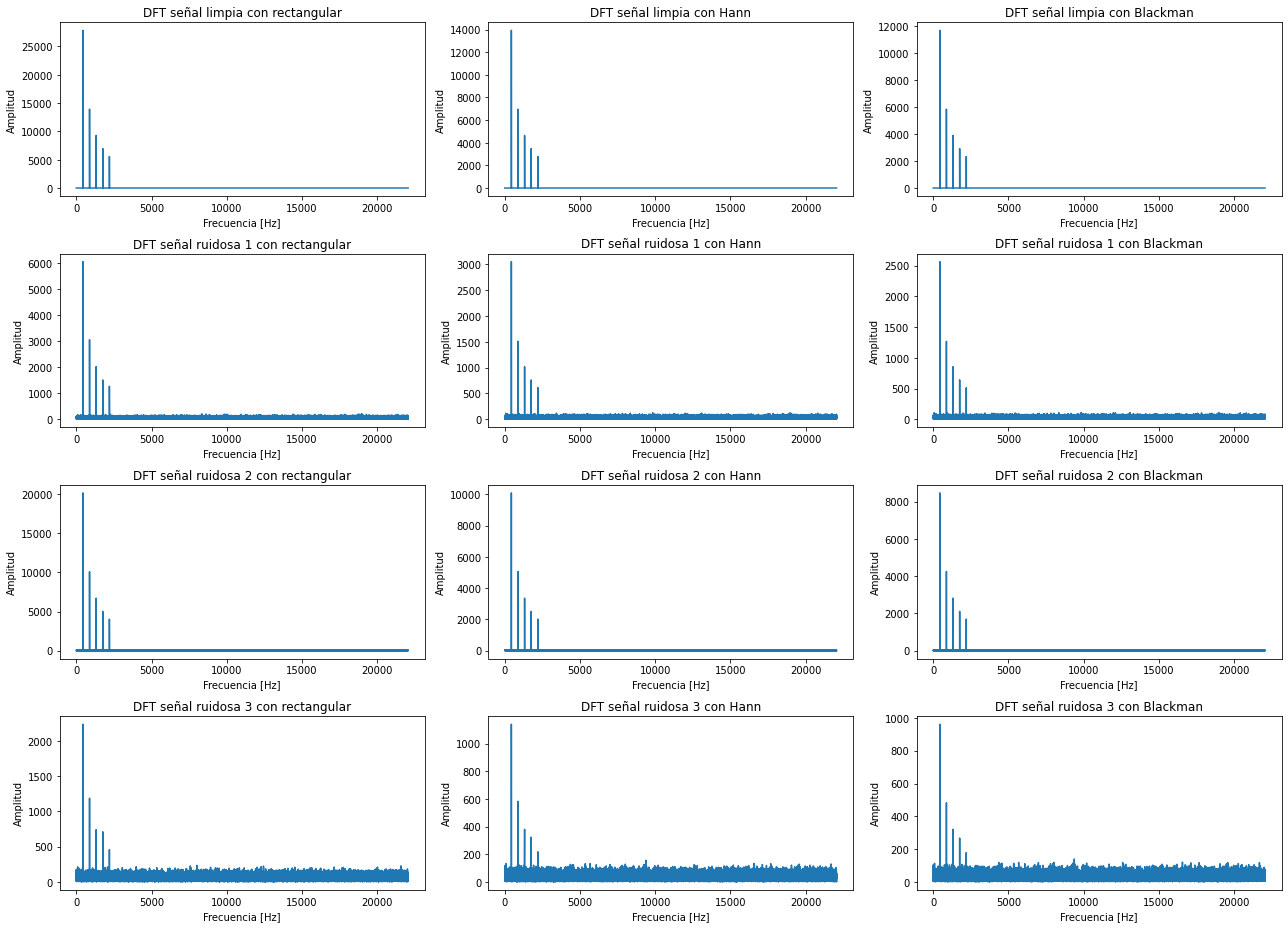

In [129]:
plt.figure(20,figsize=(18,13))
# Grafico las transformadas de la señal limpia
plt.subplot(4,3,1)
plt.plot(f, abs(A_w_dft))
plt.title("DFT señal limpia con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,2)
plt.plot(f, abs(A_h_dft))
plt.title("DFT señal limpia con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,3)
plt.plot(f, abs(A_b_dft))
plt.title("DFT señal limpia con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")

# Grafico las transformadas de la primer señal con ruido
plt.subplot(4,3,4)
plt.plot(f, abs(AX1_w_dft))
plt.title("DFT señal ruidosa 1 con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,5)
plt.plot(f, abs(AX1_h_dft))
plt.title("DFT señal ruidosa 1 con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,6)
plt.plot(f, abs(AX1_b_dft))
plt.title("DFT señal ruidosa 1 con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")

# Grafico las transformadas de la segunda señal con ruido
plt.subplot(4,3,7)
plt.plot(f, abs(AX2_w_dft))
plt.title("DFT señal ruidosa 2 con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,8)
plt.plot(f, abs(AX2_h_dft))
plt.title("DFT señal ruidosa 2 con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,9)
plt.plot(f, abs(AX2_b_dft))
plt.title("DFT señal ruidosa 2 con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")

# Grafico las transformadas de la tercer señal con ruido
plt.subplot(4,3,10)
plt.plot(f, abs(AX3_w_dft))
plt.title("DFT señal ruidosa 3 con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,11)
plt.plot(f, abs(AX3_h_dft))
plt.title("DFT señal ruidosa 3 con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.subplot(4,3,12)
plt.plot(f, abs(AX3_b_dft))
plt.title("DFT señal ruidosa 3 con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Convierto la magnitud de las transformadas en dB

In [130]:
# Ventana rectangular
A_w_dft_db = 20*np.log10(A_w_dft)
AX1_w_dft_db = 20*np.log10(AX1_w_dft)
AX2_w_dft_db = 20*np.log10(AX2_w_dft)
AX3_w_dft_db = 20*np.log10(AX3_w_dft)
# Ventana Hann
A_h_dft_db = 20*np.log10(A_h_dft)
AX1_h_dft_db = 20*np.log10(AX1_h_dft)
AX2_h_dft_db = 20*np.log10(AX2_h_dft)
AX3_h_dft_db = 20*np.log10(AX3_h_dft)
# Ventana Blackman
A_b_dft_db = 20*np.log10(A_b_dft)
AX1_b_dft_db = 20*np.log10(AX1_b_dft)
AX2_b_dft_db = 20*np.log10(AX2_b_dft)
AX3_b_dft_db = 20*np.log10(AX3_b_dft)

Gráfico de las transformadas en escala logaritmica.

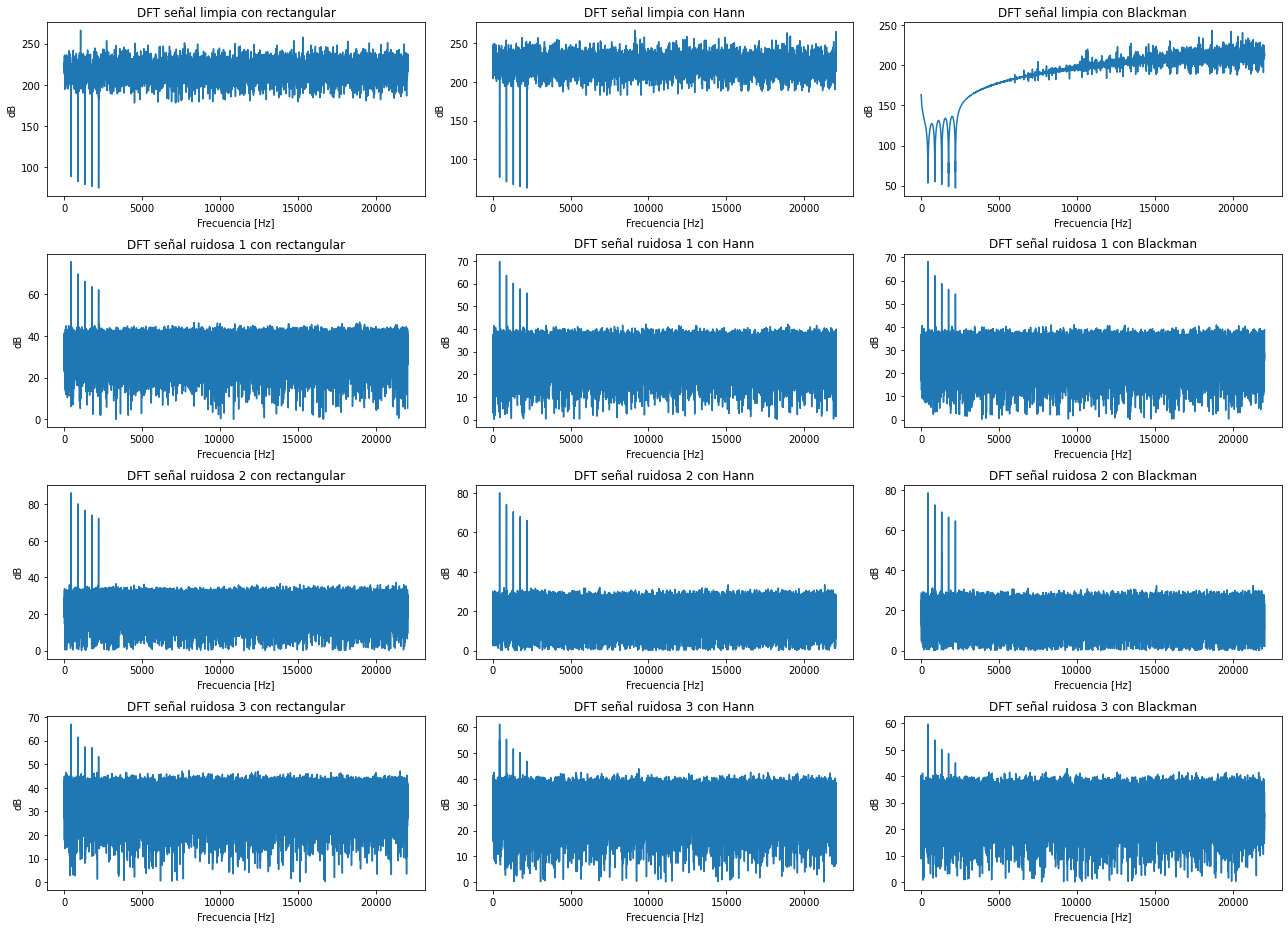

In [131]:
plt.figure(21,figsize=(18,13))
#Grafico las transformadas de la señal limpia
plt.subplot(4,3,1)
plt.plot(f, abs(A_w_dft_db))
plt.title("DFT señal limpia con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,2)
plt.plot(f, abs(A_h_dft_db))
plt.title("DFT señal limpia con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,3)
plt.plot(f, abs(A_b_dft_db))
plt.title("DFT señal limpia con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")

# Grafico las transformadas de la primer señal con ruido
plt.subplot(4,3,4)
plt.plot(f, abs(AX1_w_dft_db))
plt.title("DFT señal ruidosa 1 con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,5)
plt.plot(f, abs(AX1_h_dft_db))
plt.title("DFT señal ruidosa 1 con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,6)
plt.plot(f, abs(AX1_b_dft_db))
plt.title("DFT señal ruidosa 1 con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")

# Grafico las transformadas de la segunda señal con ruido
plt.subplot(4,3,7)
plt.plot(f, abs(AX2_w_dft_db))
plt.title("DFT señal ruidosa 2 con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,8)
plt.plot(f, abs(AX2_h_dft_db))
plt.title("DFT señal ruidosa 2 con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,9)
plt.plot(f, abs(AX2_b_dft_db))
plt.title("DFT señal ruidosa 2 con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")

# Grafico las transformadas de la tercer señal con ruido
plt.subplot(4,3,10)
plt.plot(f, abs(AX3_w_dft_db))
plt.title("DFT señal ruidosa 3 con rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,11)
plt.plot(f, abs(AX3_h_dft_db))
plt.title("DFT señal ruidosa 3 con Hann")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")
plt.subplot(4,3,12)
plt.plot(f, abs(AX3_b_dft_db))
plt.title("DFT señal ruidosa 3 con Blackman")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("dB")

plt.tight_layout()
plt.show()

Se generan nuevas ventanas con M=50

In [132]:
M_2 = 50
w_50 = 1/M_2 * np.append(np.ones(M_2), np.zeros(len(t)-M_2))
hann_50 = np.append((0.5 - 0.5 * np.cos((2*np.pi*np.arange(M_2))/M_2))/(M_2) , np.zeros(len(t)-M_2))
blackMan_50 = np.append( (0.42 - 0.5 * np.cos((2*np.pi*np.arange(M_2))/(M_2-1)) + 0.08 * np.cos((4*np.pi*np.arange(M_2))/(M_2-1))) , np.zeros(len(t)-M_2) )

Transformadas de las ventanas en decibeles

In [133]:
w_dft = rfft(w_50)
hann_dft = rfft(hann_50)
blackMan_dft = rfft(blackMan_50)

w_dft = w_dft / np.amax(w_dft)
hann_dft = hann_dft / np.amax(hann_dft)
blackMan_dft = blackMan_dft / np.amax(blackMan_dft)

w_dft_dB = 20*np.log10(np.abs(w_dft))
hann_dft_dB = 20*np.log10(np.abs(hann_dft))
blackMan_dft_dB = 20*np.log10(np.abs(blackMan_dft))

C:\Users\Ignacio\AppData\Local\Temp/ipykernel_4468/3492330163.py:9: RuntimeWarning:

divide by zero encountered in log10

C:\Users\Ignacio\AppData\Local\Temp/ipykernel_4468/3492330163.py:10: RuntimeWarning:

divide by zero encountered in log10



Defino función para obtener ancho del lóbulo principal y lo calculo para cada ventana.

In [134]:
def getLobeWidth(x, fs=44100):
    for i in range(1,len(x)):
        if np.abs(x[i]) > np.abs(x[i-1]):
            return ((i*fs)//(len(x)))

w_lobewidth = getLobeWidth(w_dft)
hann_lobewidth = getLobeWidth(hann_dft)
blackMan_lobewidth = getLobeWidth(blackMan_dft)

print('Ancho del lóbulo principal para ventana rectangular:',w_lobewidth)
print('Ancho del lóbulo principal para ventana de Hann:',hann_lobewidth)
print('Ancho del lóbulo principal para ventana de Blackman:',blackMan_lobewidth)

Ancho del lóbulo principal para ventana rectangular: 1764
Ancho del lóbulo principal para ventana de Hann: 3528
Ancho del lóbulo principal para ventana de Blackman: 5400


Se grafican las transformadas.

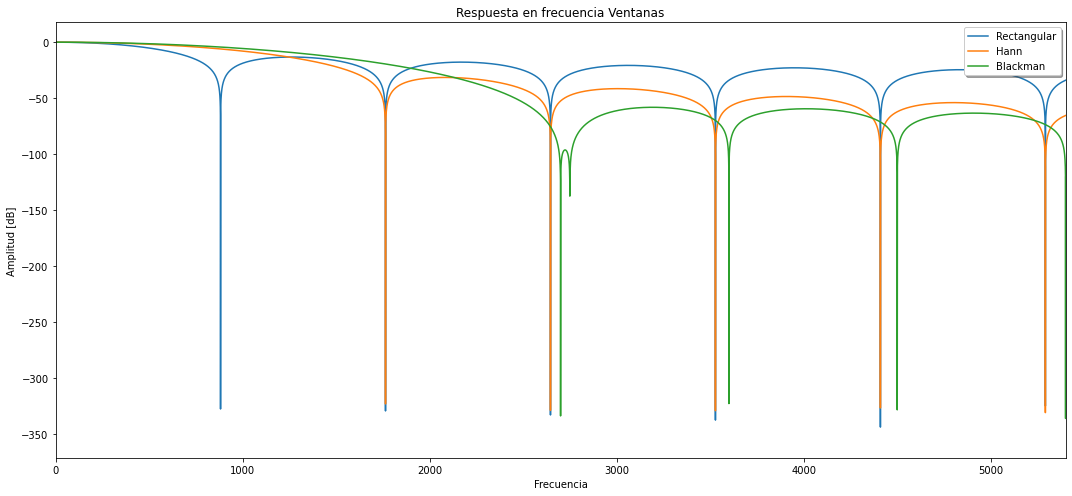

In [135]:
plt.figure(22,figsize=(15,7))
plt.plot(f,w_dft_dB, label='Rectangular')
plt.plot(f,hann_dft_dB, label='Hann')
plt.plot(f,blackMan_dft_dB, label='Blackman')
plt.title('Respuesta en frecuencia Ventanas')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud [dB]')
plt.xlim(0,np.amax([w_lobewidth,hann_lobewidth,blackMan_lobewidth]))
plt.legend(loc='upper right', shadow=True)

plt.tight_layout()
plt.show()


La DFT de la señal limpia del ejercicio 1 multiplicada por la ventana rectangular presenta cierto leaking, a diferencia de cuando es multiplicada por una ventana Hann o Blackman.

Se puede ver el componente armonico de la señal original en las respectivas transformadas, pero en la señal ruidosa 1 y 3 multiplicadas con la ventana rectangular es menos legible.

Multiplicando las señales originales con las ventanas de Hann y Blackman se pueden ver de forma mas notoria los armonicos de la señal del ejercicio 1

A medida que la desviacion estandar de la señal aumenta el ruido es mayor. Esto se puede ver comparando los graficos de las tres señales con ruido.

En el último gráfico se observan las diferencias entre los lóbulos principales y las atenuaciones de cada ventana. La ventana de Blackman presenta un lóbulo principal 3 veces más amplio que el de la rectangular y los siguientes lóbulos se ven mucho más atenuados en comparación. En el caso de la ventana de Hann, el ancho es del doble del de la rectangular y también hay una mayor atenuación de los siguientes lóbulos en relación a la rectangular, aunque no tanto como la de Blackman. En el caso de la ventana rectangular, la atenuación de los lóbulos superiores es relativamente leve con respecto a la del lóbulo principal.

## Ejercicio 12

Se genera eje de frecuencias.

In [136]:
f = np.arange(0, fs//2, (fs//2)/len(A_w_dft))

Se genera una función para calcular la reducción en dB de un filtro de media móvil de ventana M para una frecuencia dada.

In [137]:
def dBreduction_MA_f (x ,M, f, fs=44100, pref=0.00002):
    
    # Creo sinusoide de frecuencia buscada y aplico filtro MA de ancho M
    sig = np.sin(2*np.arange(len(x))*np.pi*(f/fs))

    MA = mediamovildr(sig, M)

    # Respuesta para la frecuencia buscada en dB
    res = 20*np.log10(np.amax(MA)/np.amax(sig))

    return res

Se busca mediante iteración y comparación un número de muestras de la ventana que permita una reducción que no sobrepase los 3 dB, tomando el valor anterior a una reducción mayor a -3 dB (si este es negativo también).

In [138]:
def M_for_minus3dB(x,f,fs=44100, pref=0.00002):
    for i in range(1,fs//2):
        dBdiff = dBreduction_MA_f(x,i,f)
        if dBdiff < -3 and prevDiff<0 and prevDiff>-3:
            M_minus3dB_x = i-1
            break
        prevDiff = dBdiff
    return M_minus3dB_x, prevDiff

M_minus3dB_AX1, dBdiffAX1 = M_for_minus3dB(AX1,880)
M_minus3dB_AX2, dBdiffAX2 = M_for_minus3dB(AX2,880)
M_minus3dB_AX3, dBdiffAX3 = M_for_minus3dB(AX3,880)

Las ventanas obtenidas son las siguientes.

In [139]:
print(M_minus3dB_AX1)
print(M_minus3dB_AX2)
print(M_minus3dB_AX3)

21
21
21


Todas son de 21 muestras.

Genero la respuesta del filtro de media móvil con la ventana obtenida para x1.

In [140]:
MA_3dB_880_res = (np.sin( np.pi * (np.arange(1,len(f))/(fs/2)) * 0.5 * M_minus3dB_AX1)) / ( M_minus3dB_AX1 * np.sin( np.pi * (np.arange(1,len(f))/(fs/2)) * 0.5))
MA_3dB_880_res = np.append([1],MA_3dB_880_res)
MA_3dB_880_res = np.abs(MA_3dB_880_res)/np.amax(MA_3dB_880_res)

Filtro las 3 señales con sus respectivos filtros MA y luego transformo y normalizo

In [141]:
AX1_filt880 = mediamovildr(AX1, M_minus3dB_AX1)
AX2_filt880 = mediamovildr(AX2, M_minus3dB_AX2)
AX3_filt880 = mediamovildr(AX3, M_minus3dB_AX3)

AX1_filt880_fft = np.abs(rfft(AX1_filt880))
AX2_filt880_fft = np.abs(rfft(AX2_filt880))
AX3_filt880_fft = np.abs(rfft(AX3_filt880))

AX1_filt880_fft = AX1_filt880_fft / np.amax(AX1_filt880_fft)
AX2_filt880_fft = AX2_filt880_fft / np.amax(AX2_filt880_fft)
AX3_filt880_fft = AX3_filt880_fft / np.amax(AX3_filt880_fft)

Transormo y normalizo las señales originales para comparación

In [142]:
AX1_fft = np.abs(rfft(AX1))
AX2_fft = np.abs(rfft(AX2))
AX3_fft = np.abs(rfft(AX3))

AX1_fft = AX1_fft / np.amax(AX1_fft)
AX2_fft = AX2_fft / np.amax(AX2_fft)
AX3_fft = AX3_fft / np.amax(AX3_fft)

Gráficos de la respuesta del filtro y comparación entre las señales originales y filtradas.

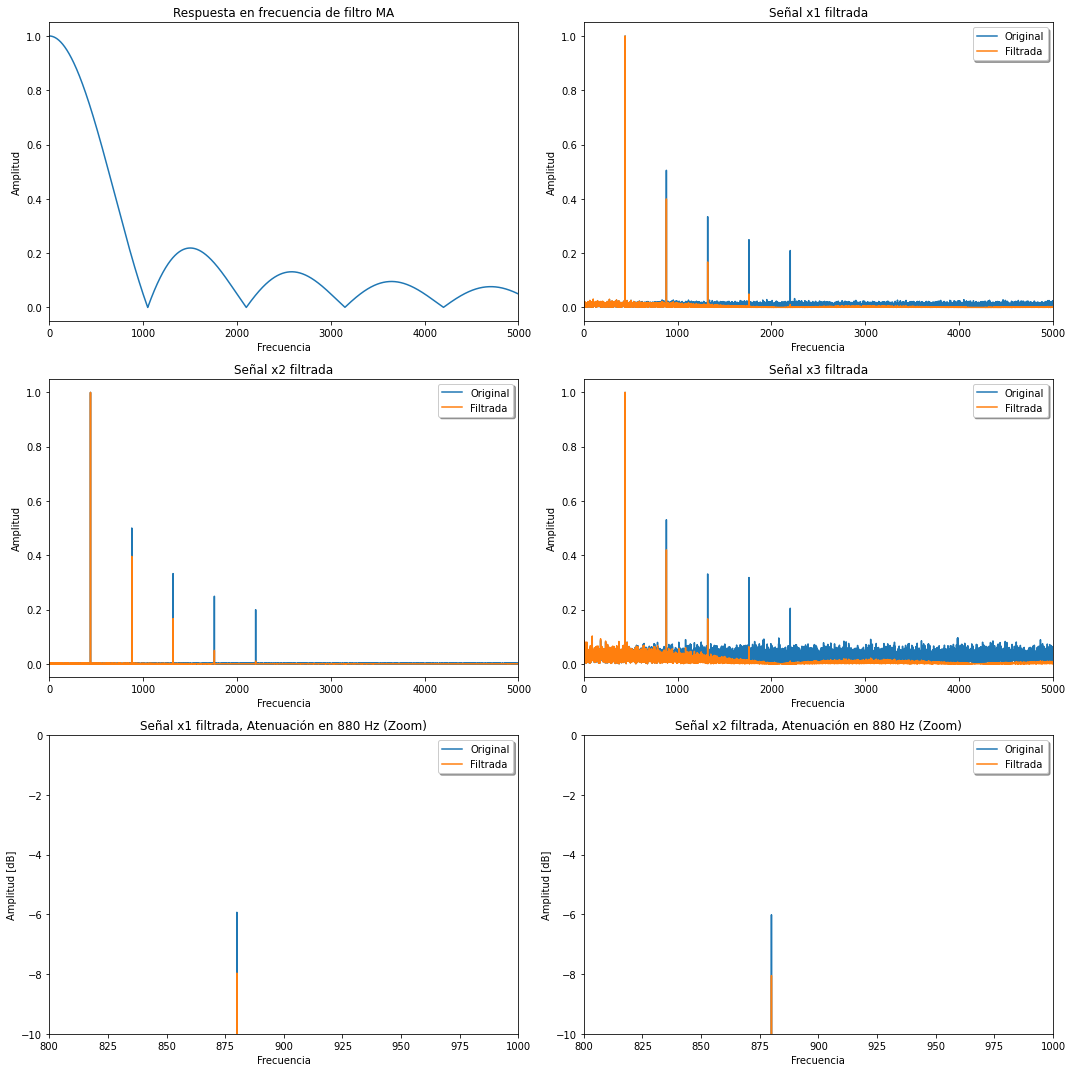

La atenuación del filtro en 880 Hz es de -2.7 dB


In [143]:
plt.figure(23,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Respuesta en frecuencia de filtro MA')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.plot(f,MA_3dB_880_res)
plt.xlim(0,5000)

f_AX = np.arange(0, fs//2, (fs//2)/len(AX1_filt880_fft))

plt.subplot(3,2,2)
plt.title('Señal x1 filtrada')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.plot(f_AX,AX1_fft, label='Original')
plt.plot(f_AX,AX1_filt880_fft, label='Filtrada')
plt.legend(loc='upper right', shadow=True)
plt.xlim(0,5000)

plt.subplot(3,2,3)
plt.title('Señal x2 filtrada')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.plot(f_AX,AX2_fft, label='Original')
plt.plot(f_AX,AX2_filt880_fft, label='Filtrada')
plt.legend(loc='upper right', shadow=True)
plt.xlim(0,5000)

plt.subplot(3,2,4)
plt.title('Señal x3 filtrada')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.plot(f_AX,AX3_fft, label='Original')
plt.plot(f_AX,AX3_filt880_fft, label='Filtrada')
plt.legend(loc='upper right', shadow=True)
plt.xlim(0,5000)

plt.subplot(3,2,5)
plt.title('Señal x1 filtrada, Atenuación en 880 Hz (Zoom)')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud [dB]')
plt.plot(f_AX,20*np.log10(AX1_fft), label='Original')
plt.plot(f_AX,20*np.log10(AX1_filt880_fft), label='Filtrada')
plt.legend(loc='upper right', shadow=True)
plt.xlim(800,1000)
plt.ylim(-10,0)

plt.subplot(3,2,6)
plt.title('Señal x2 filtrada, Atenuación en 880 Hz (Zoom)')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud [dB]')
plt.plot(f_AX,20*np.log10(AX2_fft), label='Original')
plt.plot(f_AX,20*np.log10(AX2_filt880_fft), label='Filtrada')
plt.legend(loc='upper right', shadow=True)
plt.xlim(800,1000)
plt.ylim(-10,0)

plt.tight_layout()
plt.show()

print('La atenuación del filtro en 880 Hz es de', np.round(dBreduction_MA_f(AX1,M_minus3dB_AX1,880),1), 'dB')

Comparo SNRs antes y después del filtro.

In [144]:
SNR1 = Señal_Ruido(AX1,sigma1,fs/f0)
SNR2 = Señal_Ruido(AX2,sigma2,fs/f0)
SNR3 = Señal_Ruido(AX3,sigma3,fs/f0)

SNR1_filt880 = Señal_Ruido(AX1_filt880,sigma1,fs/f0)
SNR2_filt880 = Señal_Ruido(AX2_filt880,sigma2,fs/f0)
SNR3_filt880 = Señal_Ruido(AX3_filt880,sigma3,fs/f0)

FILT880_SNR_layout = go.Layout(
    title='Relaciones Señal-Ruido para distintas desviaciones estándar luego de filtrar',
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig24 = go.Figure(data=[go.Table(header=dict(values=['Señal con ruido', 'Sigma', 'SNR original', 'SNR filtrado'],align='center'),
                cells=dict(values=[["Señal 1", "Señal 2", "Señal 3"], [sigma1, sigma2, sigma3] , [SNR1, SNR2, SNR3], [SNR1_filt880, SNR2_filt880, SNR3_filt880]],align='center'))
                ],
                layout=FILT880_SNR_layout)
fig24.show()

Se observa que el filtrado del ruido tiene mayor eficacia para el ruido de sigma=3 (Reducción del 79%), mientras que el peor caso es el de Sigma=0.1 (reducción del 40,8%).

## Ejercicio 13

Se utiliza la función stft del módulo signal de la librería scipy para desarrollar las STFTs que se requieren.

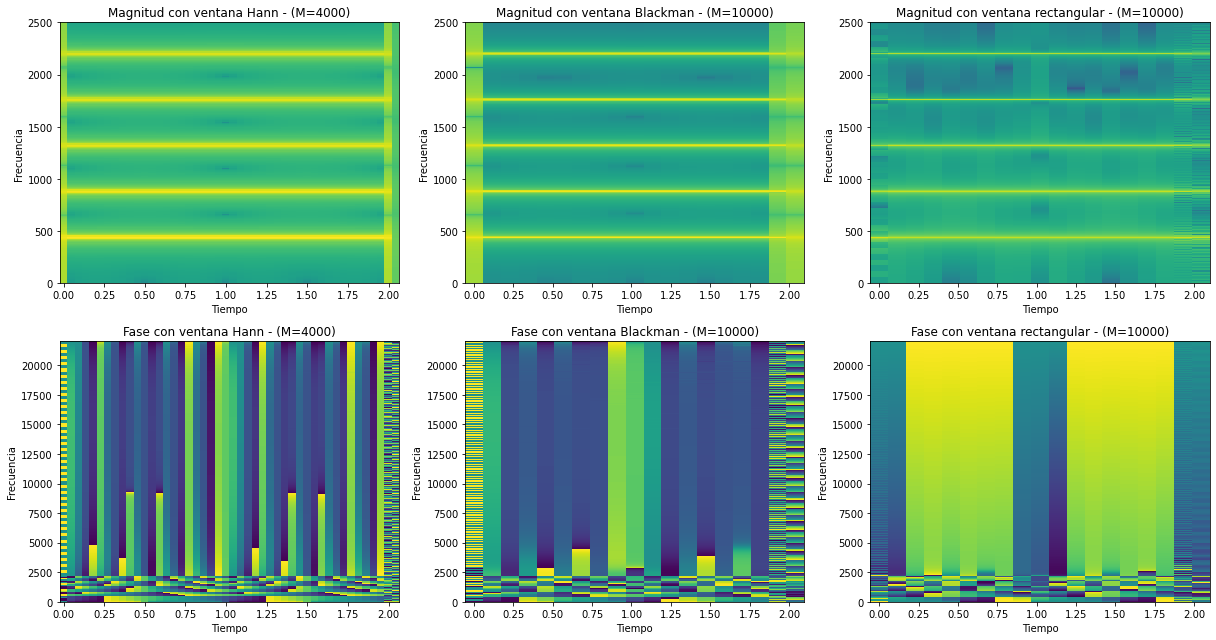

In [145]:
f1, t1, Zxx1 = sig.stft(A, fs, window='hann', nperseg=4000)
Zxx1_mag = 20 * np.log10(np.abs(Zxx1))
Zxx1_phase = np.angle(Zxx1)
# Grafico magnitud en dB
plt.figure(25, figsize=(17,9))
plt.subplot(231)
plt.pcolormesh(t1, f1, Zxx1_mag)
plt.title("Magnitud con ventana Hann - (M=4000)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.ylim(0,2500)
# Grafico fase
plt.subplot(234)
plt.pcolormesh(t1, f1, Zxx1_phase)
plt.title("Fase con ventana Hann - (M=4000)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")


f2, t2, Zxx2 = sig.stft(A, fs, window='blackman', nperseg=10000)
Zxx2_mag = 20 * np.log10(np.abs(Zxx2))
Zxx2_phase = np.angle(Zxx2)
# Grafico magnitud en dB
plt.subplot(232)
plt.pcolormesh(t2, f2, Zxx2_mag)
plt.title("Magnitud con ventana Blackman - (M=10000)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.ylim(0,2500)
# Grafico fase
plt.subplot(235)
plt.pcolormesh(t2, f2, Zxx2_phase)
plt.title("Fase con ventana Blackman - (M=10000)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")

f3, t3, Zxx3 = sig.stft(A, fs, window='boxcar', nperseg=10000)
Zxx3_mag = 20 * np.log10(np.abs(Zxx3))
Zxx3_phase = np.angle(Zxx3)
# Grafico magnitud en dB
plt.subplot(233)
plt.pcolormesh(t3, f3, Zxx3_mag)
plt.title("Magnitud con ventana rectangular - (M=10000)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.ylim(0,2500)
# Grafico fase
plt.subplot(236)
plt.pcolormesh(t3, f3, Zxx3_phase)
plt.title("Fase con ventana rectangular - (M=10000)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()



La transformada mas representativa es la de la señal multiplicada por la ventana rectangular, ya que logra una representacion mas fina a la hora de detectar las frecuencias de la señal original y la amplitud maxima es en la fundamental, luego los armonicos se ven atenuados levemente como ocurre en la señal original. 

Esto no ocurre con las otras ventanas ya que los 5 armonicos tienen la misma amplitud.

Otra transformada que puede llegar a ser util es la de la señal multiplicada por la ventana de Blackman, ya que atenua mucho mas la informacion innecesaria que hay entre un armonico y otro, pero es menos selectivo y genera informacion de tipo impulso al principio y al final del intervalo de tiempo definido. 

La multiplicada por la ventana Hann es la peor de las 3 ya que no es tan selectiva como la rectangular y no atenua tanto el intervalo de frecuencias entre dos armonicos como la Blackman.Además, la ventana de Hann también genera informacion tipo impulso al principio y al final del intervalo de tiempo.

Con lo que respecta al ancho de la ventana rectangular, entre las 2000 y 10000 muestras por segundo se logra una óptima representacion de la transformada.

En cuanto al ancho de la ventana Blackman, deberia estar entre las 5000 y 10000 muestras por segundo.
